In [ ]:
# !pip install pandas pillow opencv-python matplotlib seaborn

In [52]:
data=pd.read_csv("data_info.csv")
data['category_id']=data['category_id'] - 1

data.to_csv('data_info.csv', index=False)
data.head()

,img_id,img_path,category,category_id,x1,y1,x2,y2
0,13676,UECFOOD100/1/13676.jpg,rice,0,113.0,0.0,708.0,515.0
1,22,UECFOOD100/1/22.jpg,rice,0,310.0,200.0,500.0,375.0
2,15542,UECFOOD100/1/15542.jpg,rice,0,116.0,201.0,346.0,380.0
3,14093,UECFOOD100/1/14093.jpg,rice,0,0.0,211.0,255.0,395.0
4,21,UECFOOD100/1/21.jpg,rice,0,8.0,5.0,456.0,285.0


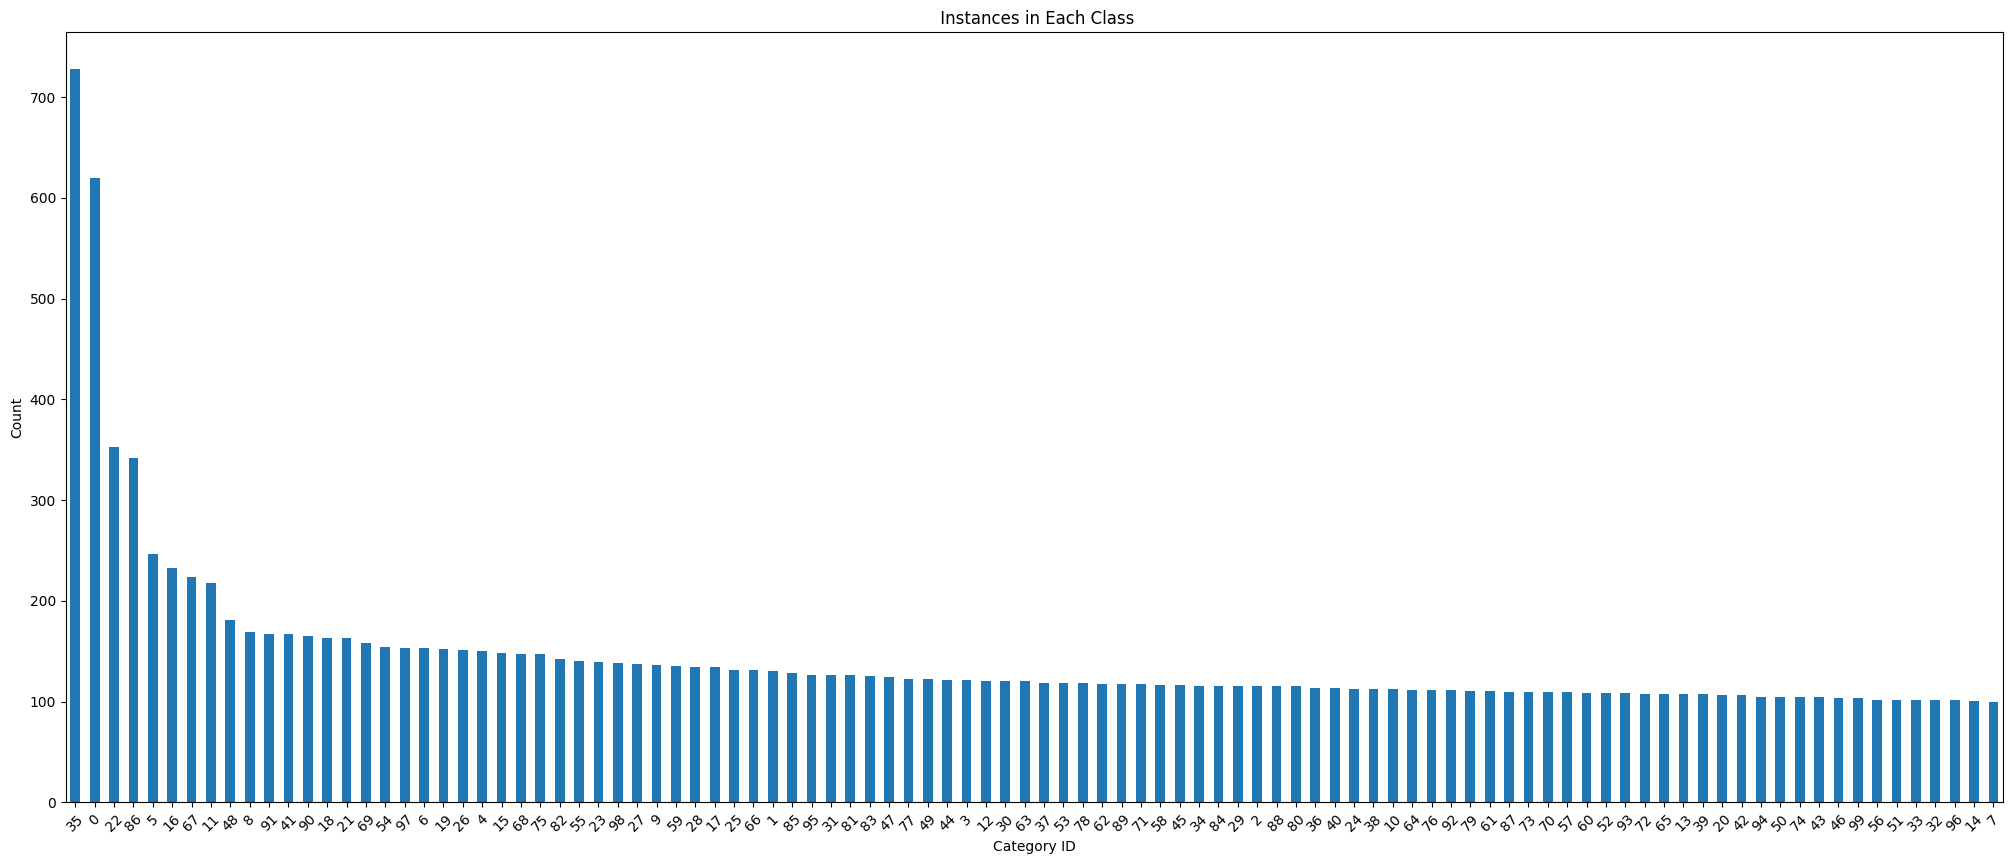

In [53]:
data=pd.read_csv('data_info.csv')
category_counts = data['category_id'].value_counts()

plt.figure(figsize=(25, 10))
category_counts.plot(kind='bar')
plt.title(' Instances in Each Class')
plt.xlabel('Category ID')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

In [54]:
data=pd.read_csv("data_info.csv")

len(data)

14361

**Data cleaning: Balance dataset**

In [15]:
import pandas as pd
import random

# Load dataset
data = pd.read_csv('data_info.csv')

# Define the target number of samples per category
target_samples_per_category = 125  

new_data = pd.DataFrame()  

for category_id, group in data.groupby('category_id'):
    if len(group) > target_samples_per_category:
        group = group.sample(n=target_samples_per_category, random_state=42)  # Randomly sample rows
    new_data = pd.concat([new_data, group])

# Reset index
new_data = new_data.reset_index(drop=True)

# Save or use new_data
print(f"Original data size: {len(data)}")
print(f"New data size: {len(new_data)}")

Original data size: 14361
New data size: 11701


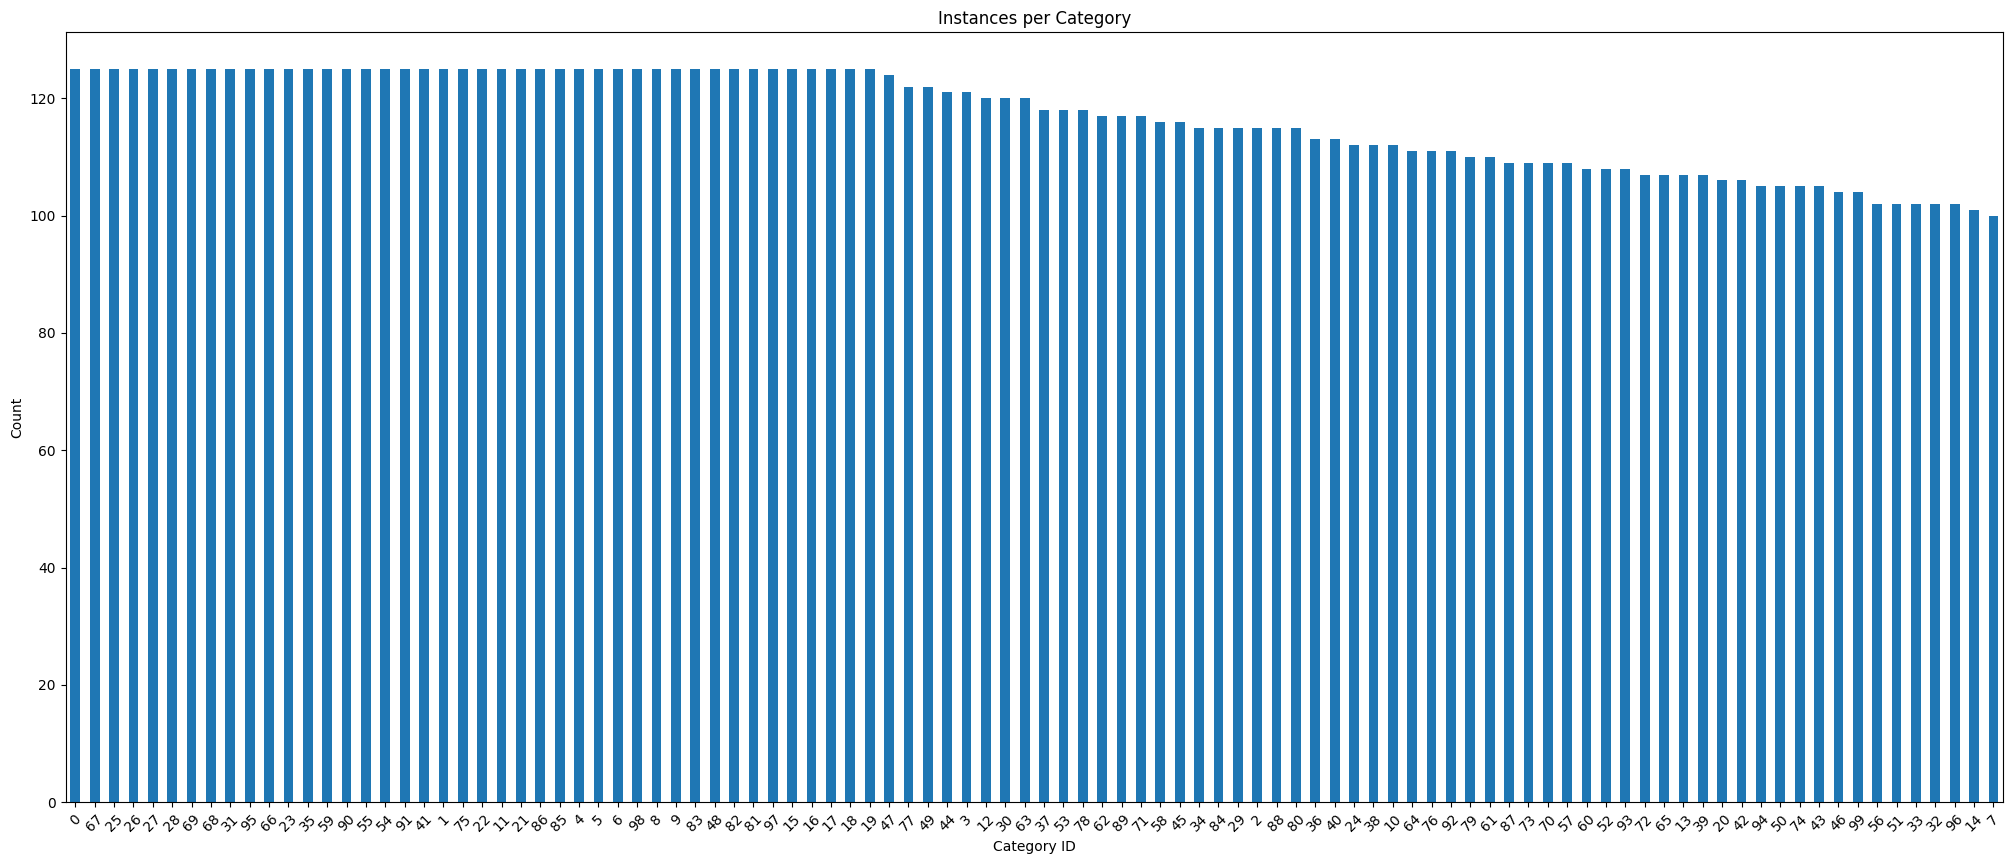

In [16]:
# data=pd.read_csv('balanced.csv')
category_counts = new_data['category_id'].value_counts()

plt.figure(figsize=(25, 10))
category_counts.plot(kind='bar')
plt.title('Instances per Category')
plt.xlabel('Category ID')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

In [17]:
# df=pd.read_csv('balanced.csv')
df = pd.DataFrame(new_data)

category_counts = df['category_id'].value_counts()

# Check if any category is underrepresented
print(f"\nMinimum Samples in a Category: {category_counts.min()}")
print(f"Maximum Samples in a Category: {category_counts.max()}")

df.head()


Minimum Samples in a Category: 100
Maximum Samples in a Category: 125


,img_id,img_path,category,category_id,x1,y1,x2,y2
0,88,UECFOOD100/1/88.jpg,rice,0,49.0,307.0,340.0,560.0
1,14006,UECFOOD100/1/14006.jpg,rice,0,170.0,98.0,282.0,214.0
2,13815,UECFOOD100/1/13815.jpg,rice,0,275.0,303.0,511.0,545.0
3,81,UECFOOD100/1/81.jpg,rice,0,10.0,169.0,276.0,404.0
4,16669,UECFOOD100/1/16669.jpg,rice,0,40.0,185.0,252.0,378.0


**Merge image that belongs to more than one category**

In [9]:
merged_df = df.groupby('img_id', as_index=False).agg({
    'img_path': 'first',
    'category': lambda x: ','.join(x),
    'category_id': lambda x: ','.join(map(str, x)),
    'x1': lambda x: ','.join(map(str, x)),
    'y1': lambda x: ','.join(map(str, x)),
    'x2': lambda x: ','.join(map(str, x)),
    'y2': lambda x: ','.join(map(str, x))
})

merged_df.head()

,img_id,img_path,category,category_id,x1,y1,x2,y2
0,1,UECFOOD100/42/1.jpg,jiaozi,41,363.0,91.0,800.0,560.0
1,5,UECFOOD100/1/5.jpg,rice,0,8.0,28.0,761.0,585.0
2,7,UECFOOD100/1/7.jpg,rice,0,0.0,162.0,383.0,450.0
3,9,UECFOOD100/1/9.jpg,"rice,beef noodle","0,23","2.0,278.0","226.0,76.0","270.0,798.0","470.0,509.0"
4,12,UECFOOD100/1/12.jpg,rice,0,94.0,150.0,669.0,567.0


**Codes to check merged dataset**

In [10]:
for i, row in merged_df.iterrows():
    category_count = len(row["category_id"].split(","))
    bbox_count = len(row["x1"].split(","))

    if category_count != bbox_count:
        print(f"⚠️ Mismatch at row {i} (Image ID: {row['img_id']}): "
              f"Categories: {row['category_id']} vs BBoxes: {row['x1']}")


In [11]:
# Create category_id to category_name mapping
category_mapping = df.set_index("category_id")["category"].to_dict()

# Check if mapping is correct
for i, row in merged_df.iterrows():
    cat_ids = row["category_id"].split(",")
    cat_names = row["category"].split(",")

    mapped_names = [category_mapping[int(cid)] for cid in cat_ids]

    if set(mapped_names) != set(cat_names):
        print(f"⚠️ Mismatch at row {i} (Image ID: {row['img_id']}): "
              f"Category Names: {cat_names} vs Mapped Names: {mapped_names}")


In [12]:
# Check dataset size before and after balancing
print(f"Original dataset size: {len(df)}")
print(f"Balanced dataset size: {len(merged_df)}")

# Ensure all categories exist in the final dataset
num_categories = merged_df["category_id"].str.split(",").explode().nunique()
print(f"✅ Unique categories in dataset: {num_categories}")


Original dataset size: 12761
Balanced dataset size: 12010
✅ Unique categories in dataset: 100


**Train the model**

In [18]:
# 🔹 Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import os
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
# 🔹 Load dataset
df = merged_df.copy()

# Convert multi-label categories into lists
if isinstance(df["category"].iloc[0], str):
    df["category"] = df["category"].apply(lambda x: x.split(","))
    df["category_id"] = df["category_id"].apply(lambda x: list(map(int, x.split(","))))  # Convert to integer list

# Convert bounding boxes into lists
df["x1"] = df["x1"].apply(lambda x: list(map(float, x.split(","))) if isinstance(x, str) else x)
df["y1"] = df["y1"].apply(lambda x: list(map(float, x.split(","))) if isinstance(x, str) else x)
df["x2"] = df["x2"].apply(lambda x: list(map(float, x.split(","))) if isinstance(x, str) else x)
df["y2"] = df["y2"].apply(lambda x: list(map(float, x.split(","))) if isinstance(x, str) else x)

In [20]:
# 🔹 Determine Maximum Bounding Boxes Per Image
MAX_BBOXES = max(df["x1"].apply(len))

print(MAX_BBOXES)

# 🔹 One-hot encode category labels
mlb = MultiLabelBinarizer()
y_labels = mlb.fit_transform(df["category_id"])
class_names = mlb.classes_
num_classes = len(class_names)

# 🔹 Image Augmentation (Only for Training)
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    horizontal_flip=True,
    brightness_range=[0.95, 1.05]
)

5


**Data Preprocessing and Augmentation Pipeline**

In [24]:
# 🔹 Function to Load and Preprocess Images
def load_image(img_path, augment=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize

    if augment:
        img = datagen.random_transform(img)  # Apply Augmentation only if specified

    img = img / 255.0  # Normalize
    return img

# 🔹 Data Generator Class
class FoodDataGenerator(Sequence):
    def __init__(self, dataframe, labels, batch_size=32, img_size=(224, 224), shuffle=True, augment=False):
        self.dataframe = dataframe
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[indexes]
        batch_labels = self.labels[indexes]

        images = []
        bboxes = []
    
        img_height, img_width = None, None  # Initialize image dimensions

        for img_path, row in zip(batch_df["img_path"], batch_df.itertuples()):
            # Check if path is already in the verified_images folder
            if not img_path.startswith("UECFOOD100/verified_images/"):
                img_path = Path(img_path).as_posix()  # Convert to POSIX-style (forward slashes)

            image = load_image(img_path, augment=self.augment)
            images.append(image)

            # Get image dimensions from the first image
            if img_height is None or img_width is None:
                img_height, img_width = image.shape[:2]

            # Process bounding boxes
            bbox_list = []
            for x1, y1, x2, y2 in zip(row.x1, row.y1, row.x2, row.y2):
                bbox_list.append([x1 / img_width, y1 / img_height, x2 / img_width, y2 / img_height])  # Normalize

            while len(bbox_list) < MAX_BBOXES:
                bbox_list.append([0.0, 0.0, 0.0, 0.0])  # Padding

            bbox_list = bbox_list[:MAX_BBOXES]  # Ensure it does not exceed MAX_BBOXES
            bboxes.append(bbox_list)

        return np.array(images), {"category_output": batch_labels, "bbox_output": np.array(bboxes)}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

**Prepare data**

In [26]:
# 🔹 Define batch size
BATCH_SIZE = 32

# 🔹 Split dataset into Train (70%), Validation (20%), and Test (10%)
train_df, temp_df, y_train, y_temp = train_test_split(df, y_labels, test_size=0.3, random_state=42)
val_df, test_df, y_val, y_test = train_test_split(temp_df, y_temp, test_size=0.33, random_state=42)  # 0.3 * 0.33 ≈ 10%

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# 🔹 Create Data Generators
train_generator = FoodDataGenerator(train_df, y_train, batch_size=BATCH_SIZE, augment=True)
val_generator = FoodDataGenerator(val_df, y_val, batch_size=BATCH_SIZE)
test_generator = FoodDataGenerator(test_df, y_test, batch_size=BATCH_SIZE, shuffle=False)


Train: 8407, Validation: 2414, Test: 1189


**Base Model**

In [67]:
# 🔹 Load MobileNetV2 as Base Model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze

**Defining, Training, and Fine-Tuning the Deep Learning Model**

In [68]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop if validation loss stops improving
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,      # Reduce LR by 50%
    patience=3,
    min_lr=1e-6,     # Minimum learning rate
    verbose=1
)

In [69]:
# 🔹 Define Model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)

# Multi-label classification output
category_output = layers.Dense(num_classes, activation="sigmoid", name="category_output")(x)

# Predict Multiple Bounding Boxes (MAX_BBOXES, 4)
bbox_output = layers.Reshape((MAX_BBOXES, 4), name="bbox_output")(
    layers.Dense(MAX_BBOXES * 4, activation="linear")(x)
)

# Define Model
model = models.Model(inputs, outputs=[category_output, bbox_output])
callbacks = [early_stopping, reduce_lr]

# 🔹 Compile Model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss={"category_output": "binary_crossentropy", "bbox_output": "mse"},
              loss_weights={"category_output": 2.0, "bbox_output": 0.1},
              metrics={"category_output": "accuracy", "bbox_output": "mae"})

# 🔹 Train Model (Initial Training)
EPOCHS = 7
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# 🔥 Unfreeze Base Model for Fine-Tuning
base_model.trainable = True


# 🔹 Recompile Model for Fine-Tuning
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={"category_output": "binary_crossentropy", "bbox_output": "mse"},
              loss_weights={"category_output": 2.0, "bbox_output": 0.1},
              metrics={"category_output": "accuracy", "bbox_output": "mae"})

EPOCHS_FINE_TUNE = 15
history_finetune = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS_FINE_TUNE, callbacks=callbacks)

# 🔹 Save Model
model.save("food_detection_model.h5")


Epoch 1/7
262/262 ━━━━━━━━━━━━━━━━━━━━ 139s 499ms/step - bbox_output_loss: 0.4149 - bbox_output_mae: 0.4688 - category_output_accuracy: 0.0185 - category_output_loss: 0.1829 - loss: 0.4073 - val_bbox_output_loss: 0.1482 - val_bbox_output_mae: 0.2848 - val_category_output_accuracy: 0.0862 - val_category_output_loss: 0.0571 - val_loss: 0.1290
Epoch 2/7
262/262 ━━━━━━━━━━━━━━━━━━━━ 127s 483ms/step - bbox_output_loss: 0.1307 - bbox_output_mae: 0.2617 - category_output_accuracy: 0.1285 - category_output_loss: 0.0554 - loss: 0.1238 - val_bbox_output_loss: 0.1103 - val_bbox_output_mae: 0.2351 - val_category_output_accuracy: 0.2163 - val_category_output_loss: 0.0503 - val_loss: 0.1117
Epoch 3/7
262/262 ━━━━━━━━━━━━━━━━━━━━ 128s 489ms/step - bbox_output_loss: 0.1012 - bbox_output_mae: 0.2231 - category_output_accuracy: 0.2711 - category_output_loss: 0.0479 - loss: 0.1060 - val_bbox_output_loss: 0.1069 - val_bbox_output_mae: 0.2243 - val_category_output_accuracy: 0.3175 - val_category_output_los

**Evaluate the model performance**

In [70]:
# 🔹 Evaluate on Test Data
results = model.evaluate(test_generator)

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - bbox_output_loss: 0.0812 - bbox_output_mae: 0.1772 - category_output_accuracy: 0.6544 - category_output_loss: 0.0267 - loss: 0.0616


**Use case of the model**

In [71]:
# Define custom objects for loading the model
custom_objects = {
    "mse": tf.keras.losses.MeanSquaredError(),
    "binary_crossentropy": tf.keras.losses.BinaryCrossentropy()
}

# Load the trained model
model = tf.keras.models.load_model("food_detection_model.h5", custom_objects=custom_objects)

# Suppress TensorFlow logging messages
tf.get_logger().setLevel('ERROR')

# Define a default confidence threshold
CONFIDENCE_THRESHOLD = 0.5  # only show predicted result above this threshold

# entire test dataset
test_subset = test_df

# Store results for comparison
results = []

for i, row in test_subset.iterrows():
    image_id = row["img_id"]
    test_img_path = row["img_path"]
    true_label = row["category_id"]

    # Load image & get prediction
    test_img = load_image(test_img_path)
    predictions = model.predict(np.expand_dims(test_img, axis=0), verbose=0)

    category_predictions = predictions[0].flatten()  # Extract and flatten category probabilities

    # Convert probabilities to labels using a threshold
    predicted_labels = [class_names[idx] for idx in range(len(category_predictions)) if category_predictions[idx] >= CONFIDENCE_THRESHOLD]

    # If no labels are predicted, take the **top-1 prediction**
    if not predicted_labels:
        predicted_labels = [class_names[np.argmax(category_predictions)]]  # Force at least one prediction

    # Store results
    results.append({
        "Image ID": image_id,
        "True Label": true_label,
        "Predicted Label": predicted_labels
    })

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)

results_df.head(100)

,Image ID,True Label,Predicted Label
0,10796,[29],[29]
1,3980,[39],[81]
2,6477,[63],[63]
3,4972,[48],[48]
4,14364,"[35, 53, 68]",[68]
...,...,...,...
95,2897,[29],[43]
96,2532,[25],[25]
97,7442,[69],[69]
98,1251,[12],[12]


In [72]:
# Count correct predictions where True Label is a subset of Predicted Labels
correct_predictions = sum(
    1 for true, pred in zip(results_df["True Label"], results_df["Predicted Label"])
    if set(true).issubset(set(pred))  # Ensures all true labels exist in predicted label
)

total_predictions = len(results_df)

accuracy = (correct_predictions / total_predictions) * 100

print(f"Prediction Accuracy: {accuracy:.2f}%")

Prediction Accuracy: 63.45%


In [73]:
data_info = pd.read_csv("data_info.csv")

data_info['category_id'] = data_info['category_id'].astype(int)

# Create a mapping from category_id → category_name
category_mapping = dict(zip(data_info['category_id'], data_info['category']))

# Create a new column 'Mapped Predicted Label' in results_df
results_df['Predicted Label Name'] = results_df['Predicted Label'].apply(lambda x: category_mapping.get(int(x[0]), 'Unknown'))
results_df['True Label Name'] = results_df['True Label'].apply(lambda x: category_mapping.get(int(x[0]), 'Unknown'))

results_df.head()

,Image ID,True Label,Predicted Label,Predicted Label Name,True Label Name
0,10796,[29],[29],gratin,gratin
1,3980,[39],[81],omelet with fried rice,omelet
2,6477,[63],[63],spicy chili-flavored tofu,spicy chili-flavored tofu
3,4972,[48],[48],grilled pacific saury,grilled pacific saury
4,14364,"[35, 53, 68]",[68],fermented soybeans,miso soup


**Visualise test result**

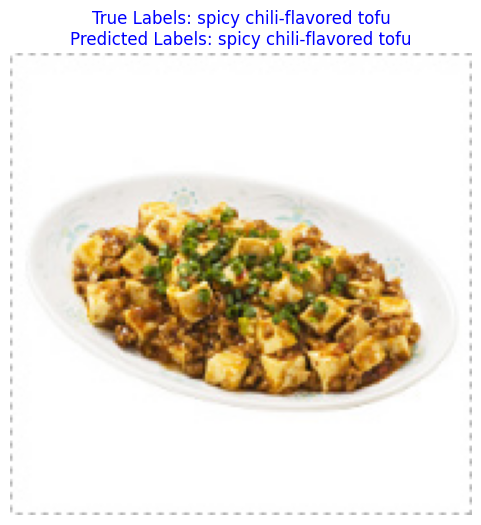

In [74]:
sample_index = 10  # Change this to demo a different prediction
sample_row = results_df.iloc[sample_index]

# Extract information
image_id = sample_row["Image ID"]
true_labels = sample_row["True Label Name"]
predicted_labels = sample_row["Predicted Label Name"]

# Get the image path from test_df
image_path = test_df.loc[test_df["img_id"] == image_id, "img_path"].values[0]

# Load and display image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Plot the image with labels
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"True Labels: {true_labels}\nPredicted Labels: {predicted_labels}", fontsize=12, color="blue")

plt.show()
